In [2]:
import h5py
import numpy as np
import keras
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.utils import multi_gpu_model
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.special import expit
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.utils import multi_gpu_model
import tensorflow as tf

Using TensorFlow backend.


In [4]:
input_img=Input(shape= (40*40,))
layer=input_img
layer=Dense(512,activation='relu')(layer)
layer=Dense(256,activation='relu')(layer)
layer=Dense(128,activation='relu')(layer)
layer=Dense(32,activation='relu')(layer)
layer=Dense(6, activation='relu')(layer)
layer=Dense(1, activation='sigmoid')(layer)

model=Model(input_img ,layer)
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())
model.summary()
#model.load_weights(".h5")
model.save_weights('densebase.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1600)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               819712    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 198       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 7         
Total para

In [70]:
# Not all NN model can benefit from the keras parallel (https://github.com/keras-team/keras/issues/9204)

GPU = 2
if GPU > 1:
    # Multi-GPU 
    parallel_model = multi_gpu_model(model, gpus=2)
    parallel_model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())
    parallel_model.save_weights('parallel_densebase.h5')

In [5]:
f = h5py.File('/pub/daohangt/hep/data/all_118370.h5','r')
ee_x = f['features']['Ecal_E'][:]
et_x = f['features']['Ecal_ET'][:]
he_x = f['features']['Hcal_E'][:]
ht_x = f['features']['Hcal_ET'][:]
print(ee_x.shape)
print(et_x.shape)
print(he_x.shape)
print(ht_x.shape)

(236740, 31, 31)
(236740, 31, 31)
(236740, 32, 32)
(236740, 32, 32)


In [6]:
ee_y = f['targets']['Ecal_E'][:]
et_y = f['targets']['Ecal_ET'][:]
he_y = f['targets']['Hcal_E'][:]
ht_y = f['targets']['Hcal_ET'][:]
print(ee_y.shape)
print(et_y.shape)
print(he_y.shape)
print(ht_y.shape)

(236740,)
(236740,)
(236740,)
(236740,)


In [37]:
# Separate bg/sig for visualizing the jet images
ee_i_bg, ee_i_sig = np.where(ee_y == 0)[0], np.where(ee_y == 1)[0]
ee_x_bg = ee_x[ee_i_bg]
ee_x_sig = ee_x[ee_i_sig]

et_i_bg, et_i_sig = np.where(et_y == 0)[0], np.where(et_y == 1)[0]
et_x_bg = et_x[et_i_bg]
et_x_sig = et_x[et_i_sig]

he_i_bg, he_i_sig = np.where(he_y == 0)[0], np.where(he_y == 1)[0]
he_x_bg = he_x[he_i_bg]
he_x_sig = he_x[he_i_sig]

ht_i_bg, ht_i_sig = np.where(ht_y == 0)[0], np.where(ht_y == 1)[0]
ht_x_bg = ht_x[ht_i_bg]
ht_x_sig = ht_x[ht_i_sig]

In [35]:
# Visualize the bg and sig jet images
def plot2(a,b,vmax,name,ta,tb):
    fig = plt.figure(figsize=(10, 10))
    row,col=1,2
    ax1 = fig.add_subplot(row,col,1)
    plt.imshow(a,cmap='Blues',vmin=-10,vmax=vmax)
    ax2 = fig.add_subplot(row,col,2)
    plt.imshow(b,cmap='Reds',vmin=-10,vmax=vmax)
    #plt.show()
    ax1.title.set_text(ta)
    ax2.title.set_text(tb)
    plt.savefig(name)
    
def plot2_nAgg(s,e,xbg,xsig,vmax,name,ta,tb):
    if len(xbg.shape) == 3:
        xbgg = np.copy(xbg[0])
        xsigg = np.copy(xsig[0])
        for i in range(s,e):
            xbgg += xbg[i]
            xsigg += xsig[i]
    else:
        xbgg = np.copy(xbg[0][0])
        xsigg = np.copy(xsig[0][0])
        for i in range(s,e):
            xbgg += xbg[i][0]
            xsigg += xsig[i][0]
    plot2(xbgg,xsigg,vmax,name,ta,tb)

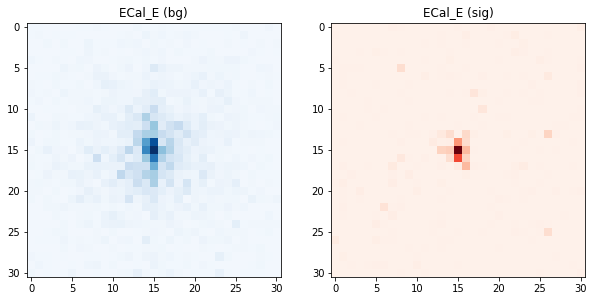

In [36]:
plot2_nAgg(0,1000,ee_x_bg,ee_x_sig,400,"ee.png",'ECal_E (bg)','ECal_E (sig)')

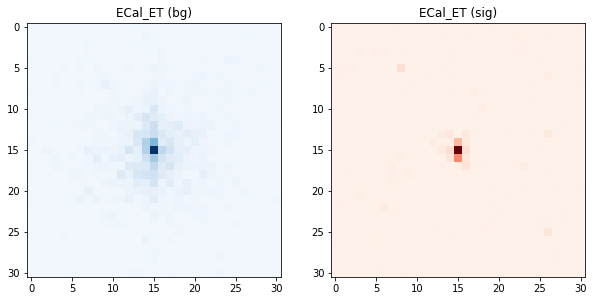

In [39]:
plot2_nAgg(0,1000,et_x_bg,et_x_sig,400,"et.png",'ECal_ET (bg)','ECal_ET (sig)')

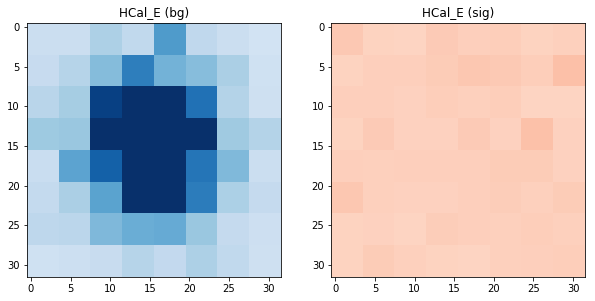

In [44]:
plot2_nAgg(0,1000,he_x_bg,he_x_sig,50,"he.png",'HCal_E (bg)','HCal_E (sig)')

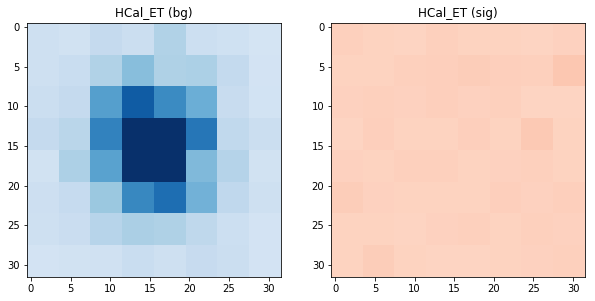

In [45]:
plot2_nAgg(0,1000,ht_x_bg,ht_x_sig,50,"ht.png",'HCal_ET (bg)','HCal_ET (sig)')

In [7]:
print("Before massaging: ")
print(ee_x.shape)
print(et_x.shape)
print(he_x.shape)
print(ht_x.shape)

def pad(x):
    if x.shape[-1] == 32:
        return np.pad(x,((0,0),(4,4),(4,4)), 'constant')
    else:
        # 31*31
        return np.pad(x,((0,0),(4,5),(4,5)), 'constant')

def extra(x):
    # Flatten individual images
    sz = (x.shape[0],x.shape[1]*x.shape[2])
    x = np.reshape(x, sz)
    return x

# Massage the data: padding + extra1
ee_x = extra(pad(ee_x))
et_x = extra(pad(et_x))
he_x = extra(pad(he_x))
ht_x = extra(pad(ht_x))

print("After massaging: ")
print(ee_x.shape)
print(et_x.shape)
print(he_x.shape)
print(ht_x.shape)

Before massaging: 
(236740, 31, 31)
(236740, 31, 31)
(236740, 32, 32)
(236740, 32, 32)
After massaging: 
(236740, 1600)
(236740, 1600)
(236740, 1600)
(236740, 1600)


In [8]:
# Splitting train & validation & test
# train & validation is used for telling overfitting
# test is used for evaluating the model (AUC)
ee_x_tr, ee_x_te, ee_y_tr, ee_y_te = train_test_split(ee_x, ee_y, test_size=0.20, random_state=42)
et_x_tr, et_x_te, et_y_tr, et_y_te = train_test_split(et_x, et_y, test_size=0.20, random_state=42)
he_x_tr, he_x_te, he_y_tr, he_y_te = train_test_split(he_x, he_y, test_size=0.20, random_state=42)
ht_x_tr, ht_x_te, ht_y_tr, ht_y_te = train_test_split(ht_x, ht_y, test_size=0.20, random_state=42)

ee_x_tr, ee_x_val, ee_y_tr, ee_y_val = train_test_split(ee_x_tr, ee_y_tr, test_size=0.20, random_state=42)
et_x_tr, et_x_val, et_y_tr, et_y_val = train_test_split(et_x_tr, et_y_tr, test_size=0.20, random_state=42)
he_x_tr, he_x_val, he_y_tr, he_y_val = train_test_split(he_x_tr, he_y_tr, test_size=0.20, random_state=42)
ht_x_tr, ht_x_val, ht_y_tr, ht_y_val = train_test_split(ht_x_tr, ht_y_tr, test_size=0.20, random_state=42)

In [9]:
# Final check for the shape
def printShape(x):
    for i in x:
        print(i.shape)

printShape((ee_x_tr, ee_x_val, ee_x_te, ee_y_tr, ee_y_val, ee_y_te)) 
printShape((et_x_tr, et_x_val, et_x_te, et_y_tr, et_y_val, et_y_te))
printShape((he_x_tr, he_x_val, he_x_te, he_y_tr, he_y_val, he_y_te))
printShape((ht_x_tr, ht_x_val, ht_x_te, ht_y_tr, ht_y_val, ht_y_te))

(151513, 1600)
(37879, 1600)
(47348, 1600)
(151513,)
(37879,)
(47348,)
(151513, 1600)
(37879, 1600)
(47348, 1600)
(151513,)
(37879,)
(47348,)
(151513, 1600)
(37879, 1600)
(47348, 1600)
(151513,)
(37879,)
(47348,)
(151513, 1600)
(37879, 1600)
(47348, 1600)
(151513,)
(37879,)
(47348,)


In [10]:
data = {"ee":[ee_x_tr, ee_x_val, ee_x_te, ee_y_tr, ee_y_val, ee_y_te],
        "et":[et_x_tr, et_x_val, et_x_te, et_y_tr, et_y_val, et_y_te],
        "he":[he_x_tr, he_x_val, he_x_te, he_y_tr, he_y_val, he_y_te],
        "ht":[ht_x_tr, ht_x_val, ht_x_te, ht_y_tr, ht_y_val, ht_y_te]}

In [12]:
def plot_al(history,aorl,t):
    plt.plot(history.history[aorl])
    plt.plot(history.history['val_'+aorl])
    plt.title(t + (" Accuracy" if aorl=="acc" else " Loss"))
    plt.ylabel(aorl)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def roc(true,pred,t):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(true, pred)
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    print(roc_auc)
    plt.figure()
    plt.plot(fpr[1], tpr[1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(t + ' ROC')
    plt.show()
    plt.savefig(t+"_dense_"+str(roc_auc[0])+".png")
    
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=5, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

In [13]:
def run_model(model, data, idx, p=False):
    lkup = {"ee":"ECal_E","et":"ECal_ET","he":"HCal_E","ht":"HCal_ET"}
    model.load_weights(('parallel_' if p else '') + 'densebase.h5')
    history = model.fit(data[idx][0], data[idx][3], epochs=20, batch_size=128, 
                    validation_data=(data[idx][1],data[idx][4]),verbose=1,
                    callbacks=callbacks)
    model.save_weights(('parallel_' if p else '') +'densebase_'+idx+'_20e_128b.h5')
    plot_al(history, 'loss', lkup[idx])
    y_hat = model.predict(data[idx][2])
    y_hat = np.reshape(y_hat,(y_hat.shape[0]))
    roc(data[idx][5], y_hat, lkup[idx])

Instructions for updating:
Use tf.cast instead.
Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 14s 89us/step - loss: 0.1116 - val_loss: 0.0741
Epoch 2/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0711 - val_loss: 0.0702
Epoch 3/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0652 - val_loss: 0.0726
Epoch 4/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0631 - val_loss: 0.0724
Epoch 5/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0618 - val_loss: 0.0773
Epoch 6/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0602 - val_loss: 0.0757
Epoch 7/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.0581 - val_loss: 0.0759


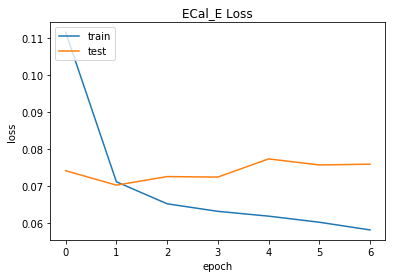

{0: 0.9960807051977703, 1: 0.9960807051977703}


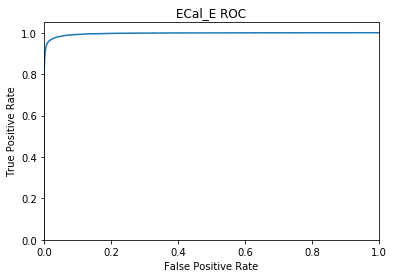

<Figure size 432x288 with 0 Axes>

In [14]:
run_model(model,data,"ee",p=False)

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0754 - val_loss: 0.0414
Epoch 2/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.0400 - val_loss: 0.0415
Epoch 3/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0366 - val_loss: 0.0431
Epoch 4/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0344 - val_loss: 0.0418
Epoch 5/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.0331 - val_loss: 0.0457
Epoch 6/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0323 - val_loss: 0.0444


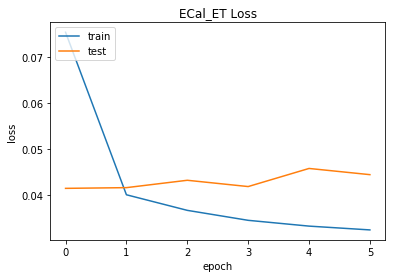

{0: 0.997863659700491, 1: 0.997863659700491}


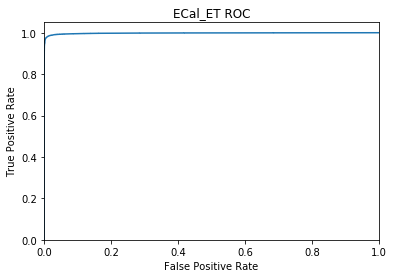

<Figure size 432x288 with 0 Axes>

In [15]:
run_model(model,data,"et",p=False)

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3811 - val_loss: 0.3712
Epoch 2/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3713 - val_loss: 0.3665
Epoch 3/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3689 - val_loss: 0.3658
Epoch 4/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3677 - val_loss: 0.3660
Epoch 5/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3662 - val_loss: 0.3673
Epoch 6/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3652 - val_loss: 0.3644
Epoch 7/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3637 - val_loss: 0.3661
Epoch 8/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3625 - val_loss: 0.3665
Epoch 9/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3

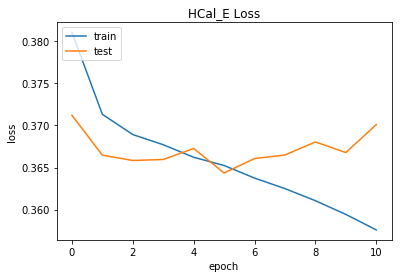

{0: 0.8898102075202972, 1: 0.8898102075202972}


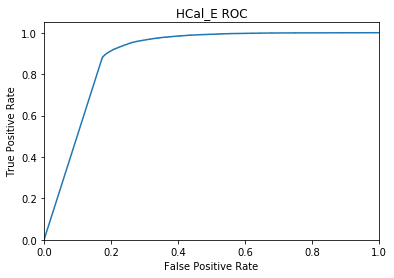

<Figure size 432x288 with 0 Axes>

In [16]:
run_model(model,data,"he",p=False)

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3684 - val_loss: 0.3553
Epoch 2/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3581 - val_loss: 0.3536
Epoch 3/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3557 - val_loss: 0.3538
Epoch 4/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3543 - val_loss: 0.3537
Epoch 5/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3529 - val_loss: 0.3538
Epoch 6/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3518 - val_loss: 0.3524
Epoch 7/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3508 - val_loss: 0.3533
Epoch 8/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3494 - val_loss: 0.3520
Epoch 9/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3

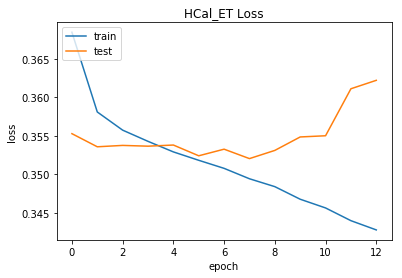

{0: 0.8924141018319919, 1: 0.8924141018319919}


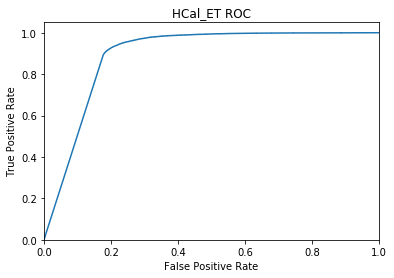

<Figure size 432x288 with 0 Axes>

In [17]:
run_model(model,data,"ht",p=False)